# Travail no. 2 – Approximation d'une fonction à l'aide d’un réseau de neurones

*J'ai décidé de créer ce notebook en m'inspirant de l'utilisation de la librairie Keras de TensorFlow. Pour ce faire, j'ai conçu des classes et recréé une version très simplifiée de l'API Sequential, avec les couches Input et Dense. Cela a pour but de me pratiquer davantage à programmer en Python en vue de mon BAC en génie logiciel à l'université.*

## Objectif

Dans votre **premier travail**, vous avez construit un polynôme de degré 3 qui approxime le mieux possible une série de données selon la méthode des moindres carrés. Le graphe de ce polynôme ne passe pas nécessairement par tous les points, mais représente **la tendance générale** des données.

Dans ce **deuxième travail**, nous allons construire une fonction similaire, mais cette fois à l’aide d’un **réseau de neurones**.

---

## Spécifications du modèle

- Un **réseau de neurones** avec :
  - Une **couche cachée unique**
  - Une **fonction d’activation** : tangente hyperbolique (`tanh`)
  - Une **fonction de perte** : somme des carrés des erreurs (**moindres carrés**)
- Les **données d’entrée et de sortie** sont normalisées pour améliorer l’entraînement.
- La fonction obtenue doit approximer **la tendance générale** des données, **comme le polynôme** du premier travail.
- Le nombre de neurones dans la couche cachée doit être **suffisant mais raisonnable**, pour éviter le **surapprentissage**.

---

## Visualisation attendue

Une fois le réseau entraîné, vous devez produire un graphique contenant :

- Les **données de la série** (nuage de points)
- Le **graphe de la fonction produite par le réseau de neurones**
- Le **graphe de la fonction polynomiale** du premier travail

> Identifiez clairement les deux courbes sur votre graphique.

**Question d’analyse** :  
Laquelle des deux courbes (réseau ou polynôme) vous semble le mieux représenter la tendance générale ?

---

## Évaluation du modèle

Calculez le **coefficient de détermination $R^2$** pour les prédictions du réseau.

La formule est :

$$
R^2 = 1 - \frac{\sum (y - \hat{y})^2}{\sum (y - \bar{y})^2}
$$

Comparez cette valeur à celle obtenue avec le polynôme.  
> Que pouvez-vous conclure concernant la **qualité de l’ajustement** fourni par le réseau de neurones ?



## Étape 1 – Importation des librairies

Nous utilisons ici :

- `numpy` pour les calculs mathématiques
- `pandas` pour lire le fichier CSV
- `matplotlib` pour visualiser les résultats

Nous initialisons également un générateur aléatoire pour assurer la reproductibilité des poids.


In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm # pour avoir une barre de progression
rng = np.random.default_rng()

np.random.seed(42)

## Étape 2 – Normalisation Z-score

Avant d'entraîner le réseau, on applique une **normalisation Z-score (cote Z)** sur les données. MinMax "brise" les résultats selon mes observations.

Formule :  
$$
x_{\text{norm}} = \frac{x - \mu}{\sigma}
$$

Ceci permet de centrer et réduire les données, ce qui facilite l'entraînement du réseau.

Nous utilisons cette normalisation sur les entrées `x` et les sorties `y` du modèle.

Cette classe est inspirée de `MinMaxScaler()` de la librairie `scikit-learn`.


In [254]:
class ZScoreScaler:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, data):
        # Enregistrer la moyenne et l'écart type pour chaque colonne pour plus tard. Ainsi, on peut les récupérer pour la transformation inverse,
        # sans qu'ils soit modifés si on fait un transform sur un autre jeu de données.
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return data * self.std + self.mean

## Étape 3 – Structure du réseau de neurones

Le réseau est défini comme suit :

- Une couche d'entrée de dimension 1
- Une **couche cachée** avec `tanh` comme fonction d'activation
- Une **couche de sortie** linéaire

### Rappel des définitions
- **Entrée $x$** : vecteur d'entrée du réseau.
- **Poids de la couche cachée $v_{ij}$** : poids entre les neurones d'entrée $x_i$ et les neurones de la couche cachée $y_j$.
- **Poids de la couche de sortie $w_j$** : poids entre les neurones de la couche cachée $y_j$ et la sortie $z$.
- **Biais de la couche cachée $b_j$** et **biais de la couche de sortie $b$**.
- **Sortie de la couche cachée $y_j$** : 
  $$
  y_j = \tanh\left( \sum_i v_{ij} x_i + b_j \right)
  $$
- **Sortie du réseau $z$** : 
  $$
  z = \sum_j w_j y_j + b
  $$

- **Fonction de perte (SSE)** : 
  $$
  \text{Loss} = (z - y_{\text{true}})^2
  $$

### Calculs des gradients pendant la rétropropagation

#### 1. Gradient de la perte par rapport à la sortie du réseau $\frac{\partial L}{\partial z}$
$$
\frac{\partial L}{\partial z} = 2 \times (z - y_{\text{true}})
$$

#### 2. Gradient de la perte par rapport aux poids de la couche de sortie $\frac{\partial L}{\partial w_j}$
Comme $z = \sum_j w_j y_j + b$, on a :
$$
\frac{\partial L}{\partial w_j} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial w_j} = 2 \times (z - y_{\text{true}}) \times y_j
$$

#### 3. Gradient de la perte par rapport au biais de la couche de sortie $\frac{\partial L}{\partial b}$
$$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial b} = 2 \times (z - y_{\text{true}})
$$

#### 4. Gradient de la perte par rapport à la sortie de la couche cachée $\frac{\partial L}{\partial y_j}$
$$
\frac{\partial L}{\partial y_j} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial y_j} = 2 \times (z - y_{\text{true}}) \times w_j
$$

#### 5. Gradient de la perte par rapport aux poids de la couche cachée $\frac{\partial L}{\partial v_{ij}}$
Comme $y_j = \tanh(\sum_i v_{ij} x_i + b_j)$, alors :
$$
\frac{\partial y_j}{\partial v_{ij}} = (1 - y_j^2) \cdot x_i
$$
Donc :
$$
\frac{\partial L}{\partial v_{ij}} = \frac{\partial L}{\partial y_j} \cdot \frac{\partial y_j}{\partial v_{ij}} = 2 \times (z - y_{\text{true}}) \times w_j \times (1 - y_j^2) \times x_i
$$

#### 6. Gradient de la perte par rapport aux biais de la couche cachée $\frac{\partial L}{\partial b_j}$
$$
\frac{\partial L}{\partial b_j} = \frac{\partial L}{\partial y_j} \cdot \frac{\partial y_j}{\partial b_j} = 2 \times (z - y_{\text{true}}) \times w_j \times (1 - y_j^2)
$$

#### 7. Gradient de la perte par rapport aux entrées $\frac{\partial L}{\partial x_i}$
$$
\frac{\partial L}{\partial x_i} = \sum_j \frac{\partial L}{\partial y_j} \cdot \frac{\partial y_j}{\partial x_i}
$$
Or,
$$
\frac{\partial y_j}{\partial x_i} = (1 - y_j^2) \cdot v_{ij}
$$
Donc :
$$
\frac{\partial L}{\partial x_i} = \sum_j 2 \times (z - y_{\text{true}}) \times w_j \times (1 - y_j^2) \times v_{ij}
$$

### Résumé des gradients

- $\frac{\partial L}{\partial z} = 2 \times (z - y_{\text{true}})$
- $\frac{\partial L}{\partial w_j} = 2 \times (z - y_{\text{true}}) \times y_j$
- $\frac{\partial L}{\partial b} = 2 \times (z - y_{\text{true}})$
- $\frac{\partial L}{\partial y_j} = 2 \times (z - y_{\text{true}}) \times w_j$
- $\frac{\partial L}{\partial v_{ij}} = 2 \times (z - y_{\text{true}}) \times w_j \times (1 - y_j^2) \times x_i$
- $\frac{\partial L}{\partial b_j} = 2 \times (z - y_{\text{true}}) \times w_j \times (1 - y_j^2)$
- $\frac{\partial L}{\partial x_i} = \sum_j 2 \times (z - y_{\text{true}}) \times w_j \times (1 - y_j^2) \times v_{ij}$

### Mise à jour des poids

Utilisés dans la descente de gradient :
$$
\text{poids} -= \text{taux d’apprentissage} \times \frac{\partial L}{\partial \text{poids}}
$$

In [255]:
# Classe de base pour toutes les couches
class Layer:
    def forward(self, inputs):
        pass  # La méthode forward (propagation avant) est définie dans les sous-classes

    def backward(self, grad_loss, learning_rate):
        pass  # La méthode backward (rétropropagation) est définie dans les sous-classes

# Couche d'entrée (point d'entrée explicite du modèle, sans poids)
class Input(Layer):
    def __init__(self, feature_dim):
        self.feature_dim = feature_dim  # Nombre de caractéristiques (dimensions) en entrée

    def forward(self, inputs):
        return inputs  # Passe les données telles quelles

    def backward(self, grad_loss, learning_rate):
        return grad_loss  # Aucun paramètre à mettre à jour, donc simplement relayer les gradients

# Couche dense entièrement connectée (avec ou sans activation)
class Dense(Layer):
    def __init__(self, units, activation=None):
        self.units = units  # Nombre de neurones dans cette couche
        self.activation = activation  # Type de fonction d'activation (ex: "tanh")
        self.weights = None  # Poids (matrice v_ij ou w_j selon la couche)
        self.bias = None  # Biais (vecteur b_j)
        self.inputs = None  # Entrées de la couche sauvegardées pour le backward

    def initialize(self, input_dim):
        # Initialisation aléatoire des poids et des biais
        self.weights = 0.02 * rng.random((input_dim, self.units)) - 0.01
        self.bias = np.zeros((1, self.units))

        # Définition de la fonction d'activation et de sa dérivée
        if self.activation == "tanh":
            self.activation_func = np.tanh  # Fonction tanh
            self.activation_grad = lambda z: 1 - np.tanh(z) ** 2  # Dérivée de tanh : 1 - tanh²(z)
        else:
            self.activation_func = lambda z: z  # Fonction linéaire (identité)
            self.activation_grad = lambda z: np.ones_like(z)  # Dérivée = 1

    # Propagation avant
    def forward(self, inputs):
        self.inputs = inputs  # Sauvegarder les entrées (x_i ou y_j) pour le backward
        # Si c'est la couche cachée, on applique la fonction d'activation sur la sortie linéaire
        # Si c'est la couche de sortie, dans le cas de la régression, on ne l'applique pas (activation linéaire)
        self.linear_output = np.dot(inputs, self.weights) + self.bias
        self.activated_output = self.activation_func(self.linear_output)
        return self.activated_output

    # Rétropropagation
    def backward(self, grad_loss, learning_rate):
        # grad_loss = dL/dy_j ou dL/dg selon la couche (cachée ou sortie)
        grad_activation = grad_loss * self.activation_grad(self.linear_output)
        # Applique la dérivée de la fonction d’activation : dy_j/dz_j

        grad_weights = np.dot(self.inputs.T, grad_activation)
        # dL/dw_j = dL/dz_j * dz_j/dw_j = dL/dz_j * y_j (ou x_i si couche cachée)

        grad_bias = np.sum(grad_activation, axis=0, keepdims=True)
        # dL/db_j = dL/dz_j

        grad_inputs = np.dot(grad_activation, self.weights.T)
        # dL/dx_i = dL/dz_j * dz_j/dx_i, pour passer à la couche précédente

        # Mise à jour des paramètres
        self.weights -= learning_rate * grad_weights
        self.bias -= learning_rate * grad_bias

        return grad_inputs  # Pour propager le gradient à la couche précédente

# Architecture séquentielle (empilement des couches)
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        self._initialize_layers()

    def _initialize_layers(self):
        input_dim = 1  # Taille de l'entrée initiale (par défaut 1)
        for layer in self.layers:
            if isinstance(layer, Input):
                continue
            layer.initialize(input_dim)
            input_dim = layer.units  # Sortie de la couche = entrée de la suivante

    # Propagation avant sur tout le réseau
    def forward(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer.forward(x)
        return x

    # Rétropropagation à travers toutes les couches (ordre inverse)
    def backward(self, grad_output, learning_rate):
        grad = grad_output
        for layer in reversed(self.layers):
            grad = layer.backward(grad, learning_rate)

    # Entraînement du réseau
    def train(self, inputs, targets, epochs, learning_rate, batch_size):
        loss_history = []

        for epoch in range(1, epochs + 1):
            with tqdm(total=batch_size, desc=f"Époque {epoch}/{epochs}", ncols=100) as pbar:
                for i in range(batch_size):
                    predictions = self.forward(inputs)
                    loss = np.sum((predictions - targets) ** 2)  # SSE
                    loss_history.append(loss)

                    grad_loss = 2 * (predictions - targets)  # dL/dy = 2(y_pred - y)
                    self.backward(grad_loss, learning_rate)

                    pbar.set_postfix(Perte=loss)
                    pbar.update(1)

        return loss_history

    def predict(self, inputs):
        return self.forward(inputs)

    def r2_score(self, y_true, y_pred):
        ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
        ss_residual = np.sum((y_true - y_pred) ** 2)
        return 1 - (ss_residual / ss_total)  # Coefficient de détermination R²



## Étape 4 – Chargement des données et entraînement du réseau de neurones 

In [256]:
# Chargement des données
data = pd.read_csv("Données.csv", header=None, names=["X", "y"])
X_raw = data["X"].to_numpy().reshape(-1, 1)
y_raw = data["y"].to_numpy().reshape(-1, 1)

data.head()

,X,y
0,6.5076,7.7864
1,10.3070,-5.8870
2,7.2197,9.7198
3,6.2995,7.2904
4,7.0027,9.6895


In [257]:
# Normalisation des données
scaler_X = ZScoreScaler()
scaler_X.fit(X_raw)
X_norm = scaler_X.transform(X_raw)

scaler_y = ZScoreScaler()
scaler_y.fit(y_raw)
y_norm = scaler_y.transform(y_raw)

In [258]:
# Création et entraînement du modèle
model = Sequential([
    Input(1), # 1 feature d'entrée (variable X)
    Dense(units=70, activation="tanh"), # Couche cachée avec n neurones et activation tanh
    Dense(units=1) # Couche de sortie avec 1 neurone (prédiction de y)
])

learning_rate = 0.001
batch_size = 1000 # Nombre d'itérations par époque
epochs = 15 # Nombre d'époques n pour l'entraînement
loss_history = model.train(X_norm, y_norm, epochs, learning_rate, batch_size)

Époque 15/15: 100%|███████████████████████████████| 1000/1000 [00:00<00:00, 1607.82it/s, Perte=2.84]


## Étape 5 – Dénormalisation et prédiction

Les prédictions du modèle sont en échelle normalisée.  
On les ramène à l’échelle originale avec la transformation inverse :

$$
y_{\text{pred}} = y_{\text{norm}} \cdot \sigma_y + \mu_y
$$


In [259]:
y_norm_pred = model.predict(X_norm)
y_pred = scaler_y.inverse_transform(y_norm_pred)

## Étape 6 – Évaluation du modèle

On évalue la performance du réseau avec le **coefficient de détermination $R^2$** :

$$
R^2 = 1 - \frac{\sum (y - \hat{y})^2}{\sum (y - \bar{y})^2}
$$

- $R^2 = 1$ : prédiction parfaite
- $R^2 = 0$ : il y a un sérieux problème...

Cela nous permet de voir si le réseau approxime bien la fonction cible $f(x)$


In [260]:
print(f"\nR² = {model.r2_score(y_raw, y_pred):.4f}")


R² = 0.9594


## Étape 7 – Visualisation

On trace :

- Les données d'origine (points noirs)
- La fonction apprise par le réseau de neurones (ligne rouge)
- La fonction obtenue lors du travail 1 (ligne bleue)

Cela permet de visualiser à quel point le modèle colle aux données.


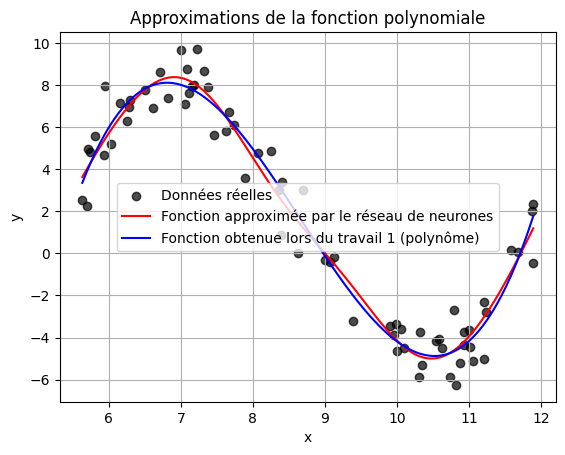

In [261]:
points_amount = 200

# Pour tracer la fonction approximée par le réseau de neurones
X_plot = np.linspace(X_raw.min(), X_raw.max(), points_amount).reshape(-1, 1)
X_plot_nn = scaler_X.transform(X_plot)  # Normalisation des points pour le réseau de neurones
y_plot_nn = model.predict(X_plot_nn)  # Prédictions du modèle
y_plot_nn = scaler_y.inverse_transform(y_plot_nn)  # Dénormalisation des résultats

# Pour tracer la fonction obtenue lors du travail 1 (polynomiale de degré 3)
coefficients = np.array([[109.2539815], [-13.21470973], [0.50835721]])  # Coefficients du polynôme de degré 3
intercept = -283.6096564371875

# Créer les puissances de X pour un polynôme de degré 3
X_plot_tp1 = np.hstack([X_plot**i for i in range(1, 4)])  # X^1, X^2, X^3

# Calculer la fonction polynomiale
y_plot_tp1 = X_plot_tp1 @ coefficients + intercept

# Tracer les données réelles, la fonction du réseau de neurones et la fonction polynomiale
plt.scatter(X_raw, y_raw, c="black", alpha=0.7, label="Données réelles")
plt.plot(X_plot, y_plot_nn, c="red", label="Fonction approximée par le réseau de neurones")
plt.plot(X_plot, y_plot_tp1, c="blue", label="Fonction obtenue lors du travail 1 (polynôme)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Approximations de la fonction polynomiale")
plt.legend()
plt.grid(True)
plt.show()


## Réponses aux questions